## Loading and Importing the necessary packages.

In [1]:
!pip install -U sentence-transformers 

     |████████████████████████████████| 78 kB 3.8 MB/s 
     |████████████████████████████████| 3.3 MB 8.3 MB/s 
     |████████████████████████████████| 3.3 MB 12.3 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
     |████████████████████████████████| 61 kB 144 kB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 895 kB 41.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=ac014b544b5cf2f23ff7e7af8880e64d1cf81f71d98573fe7a4647a3e6ff6d4e
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig

## Defining functions to preprocess the data.


> - removing stopwords, punctuations, non-alphanumerics...



In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

### Loading the dataset

> - cleaning the data and removing any Nans.



In [4]:
data_file='/content/sample_data/train_one_shot.csv'
data=pd.read_csv(data_file,encoding='ISO-8859-1')

data.head()

,DataID,Language,MWE,Setting,Previous,Target,Next,Label
0,train_one_shot.EN.147.1,EN,high life,one_shot,PSG ace Marquinhos owns this Â£170k Ferrari - ...,Despite having the riches to afford the high l...,In an interview with the French magazine 'So F...,1
1,train_one_shot.EN.183.1,EN,birth rate,one_shot,Demography expert Piotr Szukalski told Dzienni...,Minister of Family and Social Policy Marlena M...,Commenting on data the state agency Statistics...,1
2,train_one_shot.EN.213.1,EN,home run,one_shot,Negro Leagues Baseball Museum President Bob Ke...,So Aaron faced the same brutal racism other Bl...,This Black man in the deep South was about to ...,0
3,train_one_shot.EN.26.1,EN,public service,one_shot,The Nakayama Public Service Scholarship is par...,Program leaders said the scholarship defines p...,I think everyone can agree we need to do more ...,0
4,train_one_shot.EN.26.2,EN,public service,one_shot,He was absolutely right.â,"In the ensuing years, Wennberg might not have ...",Wennberg said he knew when he ran for his sixt...,1


In [5]:
data=data.dropna()
data=data.reset_index(drop=True)
print('File has {} rows and {} columns'.format(data.shape[0],data.shape[1]))
data = shuffle(data)

data.head()

File has 140 rows and 8 columns


,DataID,Language,MWE,Setting,Previous,Target,Next,Label
88,train_one_shot.PT.335.1,PT,desfile militar,one_shot,"Lutaremos atÃ© que a junta militar caiaâ, ac...",Os ataques das forÃ§as de seguranÃ§a ocorreram...,Atos violentos que afetam a seguranÃ§a e a est...,1
55,train_one_shot.EN.87.1,EN,sugar daddy,one_shot,The federal government has had a big hand in f...,At a time when many cities have undertaken Vis...,It will be critical to support rail and other ...,0
94,train_one_shot.PT.414.1,PT,primeira-dama,one_shot,"Foi feita para qualificar pessoas, formÃ¡-las,...",O aumento da cobertura do benefÃ­cio confere m...,"O governador Ronaldo Caiado, acompanhado pela ...",0
67,train_one_shot.EN.109.2,EN,loan shark,one_shot,Democrats Bernie Sanders and Alexandria Ocasio...,They call it the Loan Shark Prevention Act.,"Here's what that means for your wallet.May 28,...",1
48,train_one_shot.EN.49.1,EN,call centre,one_shot,"Paula MacNeil, CEO for the hospital foundation...",It's such a sign of the morale here at the cal...,The patient care and pediatrics fund each ensu...,1


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
data['text']=data['Target'].map(preprocess_sentence)

num_classes=len(data.Label.unique())


## Loading the DistilBERT Tokenizer and Model

In [8]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Getting the dataset ready to input in the model


> The sentences are first tokenized before they are encoded.



In [10]:
max_len=32
sentences=data['text']
labels=data['Label']
len(sentences),len(labels)

(140, 140)

In [11]:
dbert_tokenizer.tokenize(sentences[0])

['despite',
 'riches',
 'afford',
 'high',
 'life',
 'ps',
 '##g',
 'captain',
 'mar',
 '##quin',
 '##hos',
 'still',
 'touch',
 'past',
 'life',
 'becoming',
 'multi',
 'millionaire',
 'footballer']

In [12]:
dbert_inp=dbert_tokenizer.encode_plus(sentences[0],add_special_tokens = True,max_length =20,pad_to_max_length = True,truncation=True)
dbert_inp

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': [101, 2750, 26768, 8984, 2152, 2166, 8827, 2290, 2952, 9388, 12519, 15006, 2145, 3543, 2627, 2166, 3352, 4800, 19965, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
dbert_inp['input_ids']

[101,
 2750,
 26768,
 8984,
 2152,
 2166,
 8827,
 2290,
 2952,
 9388,
 12519,
 15006,
 2145,
 3543,
 2627,
 2166,
 3352,
 4800,
 19965,
 102]

In [14]:
id_inp=np.asarray(dbert_inp['input_ids'])
mask_inp=np.asarray(dbert_inp['attention_mask'])
out=dbert_model([id_inp.reshape(1,-1),mask_inp.reshape(1,-1)])
type(out),out

(transformers.modeling_tf_outputs.TFBaseModelOutput,
 TFBaseModelOutput([('last_hidden_state',
                     <tf.Tensor: shape=(1, 20, 768), dtype=float32, numpy=
                     array([[[-0.2753749 , -0.09111639,  0.24140027, ..., -0.35560158,
                               0.40902442,  0.01137051],
                             [-0.43566227,  0.23103459,  0.5313838 , ..., -0.500296  ,
                               0.28114966, -0.04933707],
                             [-0.18994816,  0.04063627,  0.43090287, ..., -0.3554795 ,
                               0.24658328, -0.23500589],
                             ...,
                             [ 0.27422267, -0.33334315,  0.86090684, ..., -0.3099606 ,
                               0.28382498, -0.3553204 ],
                             [ 0.01487566, -0.56396866,  0.4442913 , ..., -0.23899232,
                               0.22856326, -0.66691244],
                             [ 0.6737199 ,  0.13829362, -0.02409783, ..., -0

- To check the embeddings of a sentence from the output, one can run the code below.

In [15]:
# out[0][:,0,:]

In [ ]:
dbert_tokenizer.decode(dbert_inp['input_ids'])

'[CLS] despite having the riches to afford the high life, psg captain marquinhos is still [SEP]'

## Creating the model 

In [40]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model   

In [39]:
model=create_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_5[0][0]',                
 BertModel)                     ast_hidden_state=(N               'input_6[0][0]']                
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

### Preparing the data for the model.

In [41]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,padding = "max_length", return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [42]:
len(input_ids),len(attention_masks),len(labels)

(140, 140, 140)

- Saving the model input data in pickle files save them for later use.

In [43]:
import os

path = "/content/sample_data/data2"
os.mkdir(path)
# path2 = "/content/sample_data/data/dbert_mask.pkl"
# os.mkdir(path2)
# path3 = "/content/sample_data/data/dbert_label.pkl"
# os.mkdir(path3)

FileExistsError: ignored

In [44]:


pickle_inp_path='/content/sample_data/data2/dbert_inp.pkl'
pickle_mask_path='/content/sample_data/data2/dbert_mask.pkl'
pickle_label_path='/content/sample_data/data2/dbert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Pickle files saved as  /content/sample_data/data2/dbert_inp.pkl /content/sample_data/data2/dbert_mask.pkl /content/sample_data/data2/dbert_label.pkl


- Loading the files back.

In [45]:


input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Input shape (140, 32) Attention mask shape (140, 32) Input label shape (140,)


In [46]:
label_class_dict={0:'lit',1:'idiom'}
target_names=label_class_dict.values()

In [47]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='./dbert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (112, 32) Val input shape (28, 32)
Train label shape (112,) Val label shape (28,)
Train attention mask shape (112, 32) Val attention mask shape (28, 32)


In [48]:
callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

## Model Training

In [51]:
history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=10,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/10
7/7 [==============================] - 35s 5s/step - loss: 5.8617 - accuracy: 1.0000 - val_loss: 7.3855 - val_accuracy: 0.5714
Epoch 2/10
7/7 [==============================] - 20s 3s/step - loss: 5.8109 - accuracy: 1.0000 - val_loss: 7.5345 - val_accuracy: 0.5357
Epoch 3/10
7/7 [==============================] - 20s 3s/step - loss: 5.7682 - accuracy: 1.0000 - val_loss: 7.5796 - val_accuracy: 0.6071
Epoch 4/10
7/7 [==============================] - 20s 3s/step - loss: 5.7354 - accuracy: 1.0000 - val_loss: 7.6335 - val_accuracy: 0.6071
Epoch 5/10
7/7 [==============================] - 21s 3s/step - loss: 5.6965 - accuracy: 1.0000 - val_loss: 7.7456 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 21s 3s/step - loss: 5.6599 - accuracy: 1.0000 - val_loss: 7.8810 - val_accuracy: 0.5357
Epoch 7/10
7/7 [==============================] - 29s 4s/step - loss: 5.6240 - accuracy: 1.0000 - val_loss: 7.9396 - val_accuracy: 0.5357
Epoch 8/10
7/7 [==================

GRAPH history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


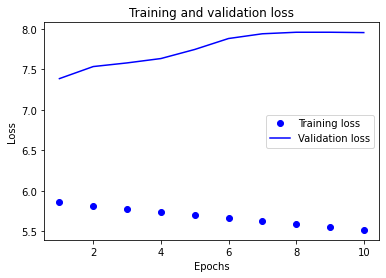

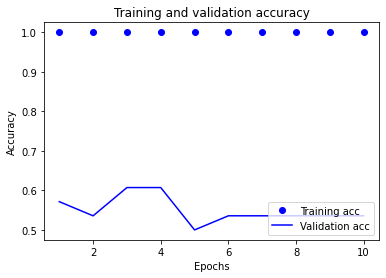

In [55]:
# graphs 

history_dict = history.history
history_dict.keys()
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()